# Random Forest Model

__Imports__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler


style.use('fivethirtyeight')
# import jupyterthemes as jt
# context = jt.jtplot.set_context('poster')
# jt.jtplot.set_style(context, 'monokai', ticks=True, spines=True)
# jt.stylefx.style_layout('nb_style', theme='monokai',
#                         toolbar=True, nbname=True, cellwidth='1000')
# jt.stylefx.set_nb_theme('monokai')


## Read in the data and instantiate models

In [2]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [3]:
feat = ['attribute2', 'attribute4', 'attribute7',
        'attribute8']  
features = df[feat]
labels = df['failure']

In [17]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    shuffle=False)

In [5]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [6]:
rf = RandomForestClassifier(max_depth=None,
                            n_estimators=15, 
                            max_features=None,
                            min_samples_leaf=450,
                            n_jobs=-1,
                            random_state=42,
                            class_weight='balanced_subsample')

rf.fit(X_train_ss, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=450,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=15, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

## Model Evaluation

In [7]:
rf.score(X_train_ss, y_train)

0.9294955553175538

In [8]:
rf.score(X_test_ss, y_test)

0.9444801439403676

In [9]:
preds = rf.predict(X_test_ss)

# Generate confusion matrix.
confusion_matrix(
    y_test,  
    preds)  

array([[29377,  1721],
       [    7,    19]], dtype=int64)

In [10]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9447
Sensitivity: 0.7308


### ROC AUC 

In [15]:
rf.predict_proba(X_test_ss).shape

(31124, 2)

In [16]:
y_test

93370     0
93371     0
93372     0
93373     0
93374     0
         ..
124489    0
124490    0
124491    0
124492    0
124493    0
Name: failure, Length: 31124, dtype: int64

In [18]:
pred_proba = [i[1] for i in rf.predict_proba(X_test_ss)]

pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

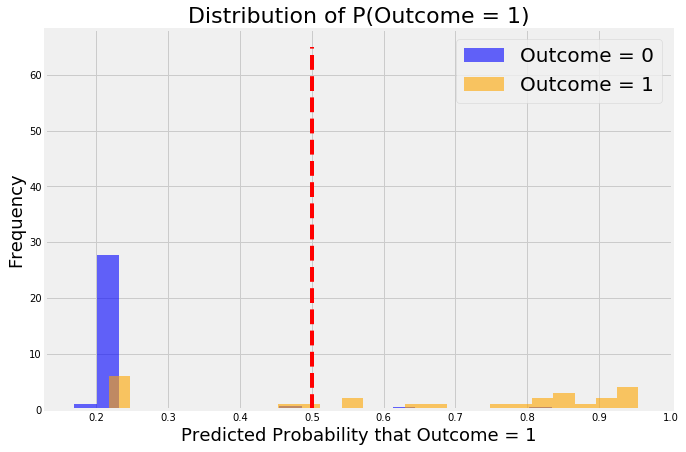

In [11]:
pred_proba = [i[1] for i in rf.predict_proba(X_test_ss)]

pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

# Create figure.
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0',
         density=True)

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20)

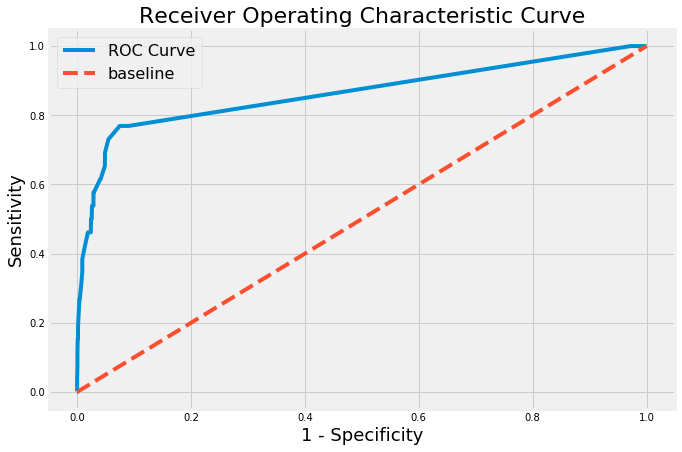

In [12]:
# Create figure.
plt.figure(figsize=(10, 7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)


def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)


def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

In [13]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8622400896421734

## Results

After some parameter tuning, the `RandomForestClassifier` was able to improve upon the logistic regression models.  It was significantly better at predicting if a device was failing although had slightly lower specificity.

In [14]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     31098
           1       0.01      0.73      0.02        26

    accuracy                           0.94     31124
   macro avg       0.51      0.84      0.50     31124
weighted avg       1.00      0.94      0.97     31124

